数据集加载完成！
开始训练...
Epoch 1/10: Train Loss: 14.0984, Train Acc: 0.098, Test Acc: 0.096
Epoch 2/10: Train Loss: 13.3601, Train Acc: 0.099, Test Acc: 0.097
Epoch 3/10: Train Loss: 14.1232, Train Acc: 0.100, Test Acc: 0.101
Epoch 4/10: Train Loss: 13.2541, Train Acc: 0.099, Test Acc: 0.098
Epoch 5/10: Train Loss: 13.3842, Train Acc: 0.101, Test Acc: 0.101
Epoch 6/10: Train Loss: 14.5545, Train Acc: 0.098, Test Acc: 0.098
Epoch 7/10: Train Loss: 14.2137, Train Acc: 0.101, Test Acc: 0.114
Epoch 8/10: Train Loss: 14.0523, Train Acc: 0.098, Test Acc: 0.114
Epoch 9/10: Train Loss: 13.4942, Train Acc: 0.101, Test Acc: 0.098
Epoch 10/10: Train Loss: 14.1900, Train Acc: 0.101, Test Acc: 0.103

训练总耗时：139.23 秒（约 2.32 分钟）


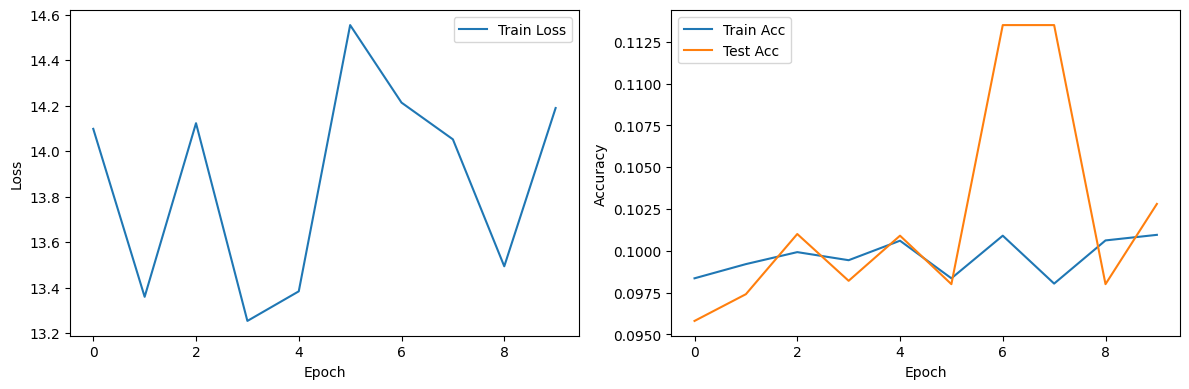

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# 1. 加载MNIST数据集
def load_data_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
    print("数据集加载完成！")
    return (
        DataLoader(train_data, batch_size, shuffle=True, num_workers=2),
        DataLoader(test_data, batch_size, shuffle=False, num_workers=2)
    )

# 2. 错误设计的卷积神经网络（激活函数 + 权重初始化）
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.fc2 = nn.Linear(500, 10)

        # ❌ 错误初始化：所有权重初始化为常数 0.5，bias 为 0，破坏参数多样性
        for layer in [self.conv1, self.conv2, self.fc1, self.fc2]:
            nn.init.constant_(layer.weight, 0.5)
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        out = torch.sigmoid(self.conv1(x))         # ❌ 使用 Sigmoid（容易梯度消失）
        out = torch.max_pool2d(out, 2, 2)
        out = torch.sigmoid(self.conv2(out))       # ❌ 同上
        out = out.view(out.size(0), -1)
        out = torch.sigmoid(self.fc1(out))         # ❌ 同上
        out = self.fc2(out)                        # 最后一层不加激活函数
        return out

# 3. 模型训练与评估（带耗时统计）
def train_model(net, train_iter, test_iter, num_epochs=10, lr=0.1):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loss_list, train_acc_list, test_acc_list = [], [], []

    print("开始训练...")
    start_time = time.time()

    for epoch in range(num_epochs):
        net.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for X, y in train_iter:
            output = net(X)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (output.argmax(dim=1) == y).sum().item()
            total_samples += y.size(0)

        train_loss = total_loss / len(train_iter)
        train_acc = total_correct / total_samples

        # 测试
        net.eval()
        test_correct, test_samples = 0, 0
        with torch.no_grad():
            for X, y in test_iter:
                output = net(X)
                test_correct += (output.argmax(dim=1) == y).sum().item()
                test_samples += y.size(0)
        test_acc = test_correct / test_samples

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.3f}, '
              f'Test Acc: {test_acc:.3f}')

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"\n训练总耗时：{elapsed:.2f} 秒（约 {elapsed / 60:.2f} 分钟）")

    # 可视化
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 4. 主函数入口
if __name__ == '__main__':
    torch.manual_seed(42)
    batch_size = 256
    num_epochs = 10
    learning_rate = 0.1

    train_iter, test_iter = load_data_mnist(batch_size)
    model = ConvNet()
    train_model(model, train_iter, test_iter, num_epochs, learning_rate)
